In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# going to the repository of this note book
%cd drive/My Drive/Thesis/CPNN_PiggyBack
!ls

/content/drive/My Drive/Thesis/CPNN_PiggyBack
data		     iris-model.pickle	performance	   requirements.txt  Untitled0.ipynb
datasets	     lab		push_to_git.ipynb  results
iris-model-full.pth  models		README.md	   run_test


In [3]:
# IMPORT
import torch
import os
# this module is for training and functions related to data preparation
from models.training import *
from models.cpnn import *
# this is for importing pretrain models.
from models.pretrain import *

#from models.cpnn_others import cPNNExp
#from models.cpnn_seq import cPNNSeq
#from models.cgru_double import cGRULinearDouble
#from models.clstm import *

import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
import argparse
from torch.autograd import Variable
import pprint
import copy


In [8]:
# EDITABLE PARAMETERS
dataset = "sine_rw10_mode5_extended_6-6_1234"

# OTHER PARAMETERS
batch_size = 128
hidden_size = 50
seq_len = 10
# TODO
iterations = 1
loss_on_seq = False
freeze_inputs_weights = False
pretraining_samples = 0
pretraining_epochs = 0
write_weights = False
combination = False
model_type='GRU'
if model_type == "GRU":
    model_class = GRU_Model
else:
    model_class = LSTM_Model

path = os.path.join(
    "performance/pretrain_GRU"
)

In [9]:
df = pd.read_csv("datasets/datasets/sine_rw10_mode5_extended_6-6_1234.csv")
df_task1 = df[df["task"] == 1][0:100*128]
df_task2 = df[df["task"] == 2][0:100*128]

#df_task = df_task.drop(columns="task")
merged_df = pd.concat([df_task1, df_task2], axis=0)
merged_df = merged_df.drop(columns="task")
merged_df

,x1,x2,target
0,0.718354,0.957244,0
1,0.725173,0.952800,0
2,0.772454,0.922077,0
3,0.803595,0.872254,0
4,0.148729,0.872254,0
...,...,...,...
62795,0.521257,0.163545,1
62796,0.561666,0.211509,1
62797,0.542095,0.222144,1
62798,0.538901,0.191803,1


In [10]:
Model = GRU_Model(input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
          )
instance = cPNN(seq_len=seq_len)

In [11]:
if len(merged_df) % batch_size == 0:
  n_batches = int(len(merged_df) / batch_size)
else:
  n_batches = int(len(merged_df) / batch_size) + 1
x=[]
y=[]
for i in range(0, len(merged_df), batch_size):
  x.append(merged_df.iloc[i : i + batch_size, 0:-1].values.astype(np.float32))
  y.append(list(merged_df.iloc[i : i + batch_size, -1]))
np.random.seed(42)  # Set a seed for reproducibility
indices = np.random.permutation(len(x))
x = np.array(x)
y = np.array(y)
# Shuffle both X and Y arrays based on the indices
x_shuffled = x[indices]
y_shuffled = y[indices]

In [12]:
x_shuffled

array([[[0.7104885 , 0.11812691],
        [0.712329  , 0.13130072],
        [0.70768   , 0.15779382],
        ...,
        [0.96058536, 0.29139912],
        [0.9163318 , 0.28801548],
        [0.63128686, 0.28801548]],

       [[0.7847214 , 0.1889966 ],
        [0.7802099 , 0.22292699],
        [0.80950284, 0.17685685],
        ...,
        [0.5134001 , 0.30190942],
        [0.5032712 , 0.29642382],
        [0.8425633 , 0.29642382]],

       [[0.64615005, 0.24623059],
        [0.68922436, 0.21700577],
        [0.67622787, 0.26421827],
        ...,
        [1.0466331 , 0.09969607],
        [1.013417  , 0.13359435],
        [1.0113673 , 0.09910103]],

       ...,

       [[0.30873692, 0.66233325],
        [0.34979653, 0.70523715],
        [0.5057566 , 0.70523715],
        ...,
        [0.5382389 , 0.35265565],
        [0.4986476 , 0.37636244],
        [0.48067707, 0.36459056]],

       [[0.5660044 , 0.49818623],
        [0.6018725 , 0.5176859 ],
        [0.5776521 , 0.48948574],
        .

In [13]:
x = np.array(x)
x.shape

(200, 128, 2)

In [14]:
x.shape[0]

200

In [15]:
if len(merged_df) % batch_size == 0:
  n_batches = int(len(merged_df) / batch_size)
else:
  n_batches = int(len(merged_df) / batch_size) + 1

optimizer = torch.optim.Adam(Model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
out_h = None
for j in range(0,5):
  for i in range(0,x_shuffled.shape[0], 1):
    x = x_shuffled[i]
    y = y_shuffled[i]
    if len(y) >= seq_len:
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = Model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      loss = loss_fn(y_pred, y)
      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()


In [16]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(Model.state_dict())

OrderedDict([   (   'gru.weight_ih_l0',
                    tensor([[-5.7705e-01, -3.0893e-01],
        [ 2.1975e-02,  3.2612e-01],
        [ 6.9677e-02, -2.1299e-01],
        [ 2.2354e-01,  1.4649e-01],
        [-1.4599e-04, -7.1644e-01],
        [-3.2716e-01, -9.1710e-01],
        [ 4.3130e-01, -4.9916e-01],
        [-5.2757e-02, -7.1526e-01],
        [ 1.0420e-01, -1.6784e+00],
        [-9.5562e-02, -1.1641e+00],
        [-1.7072e-01,  5.5631e-01],
        [-4.5978e-01, -7.8282e-01],
        [-5.5720e-01, -1.2529e+00],
        [-6.1809e-01, -5.7958e-01],
        [-3.4727e-01,  1.4097e-02],
        [ 1.6878e-02, -2.3214e-02],
        [-4.6333e-01, -9.7236e-01],
        [-6.6422e-01,  2.4628e-01],
        [-3.2017e-01, -4.3076e-01],
        [-4.6900e-01, -9.3804e-01],
        [-5.0894e-01, -8.3661e-02],
        [-9.8432e-03, -1.3536e-02],
        [-4.1388e-01,  1.1253e+00],
        [-6.2289e-01, -1.1098e+00],
        [-8.8398e-01, -8.1565e-01],
        [-4.3580e-01,  1.0226e-01],
    

In [17]:
# Save model
with open("performance/pretrain/pretrain_mode_gru_hidden50_sine_rw10_mode5_extended_6-6_1234_12.pickle", "wb") as fp:
    pickle.dump(Model.state_dict(), fp)

## trying to read the weights of the pretrain model

In [ ]:
pretrain_model = PretrainModel(input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
          )
with open("performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_4.pickle", "rb") as fp:
    pretrain_model.load_state_dict(pickle.load(fp),strict=False)

In [ ]:
import statistics

In [ ]:
df = pd.read_csv("datasets/datasets/sine_rw10_mode5_extended_16-16_1234.csv")
for task in range(1, df["task"].max() + 1):
  acc=[]
  df_task = df[df["task"] == task]
  df_task = df_task.drop(columns="task")
  for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if len(y) >= seq_len:
        x = np.array(x)
        y = list(y)
        x, y, _ = instance._load_batch(x, y)
        y_pred = pretrain_model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)
        acc.append(accuracy_score(np.array(y),np.array(pred)))
  print(statistics.mean(acc))


0.35121882992327363
0.20711317135549873
0.6440776854219948
0.8104859335038364


In [ ]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(pretrain_model.state_dict())

OrderedDict([   (   'gru.weight_ih_l0',
                    tensor([[ 4.9395e-01,  7.2624e-01],
        [-2.5023e-01, -1.5779e+00],
        [ 4.2910e-02, -2.2821e-03],
        [-2.7951e-01, -9.4084e-02],
        [-4.2295e-01, -2.2655e-01],
        [-7.1322e-01, -6.1827e-01],
        [-1.0246e-02, -3.2005e-01],
        [-4.1410e-01, -1.2440e+00],
        [-7.2617e-01, -7.9609e-01],
        [-5.6529e-01, -9.9232e-01],
        [-5.3829e-01, -1.3724e+00],
        [-4.4110e-01, -1.1477e+00],
        [-4.6161e-01, -9.9819e-01],
        [-3.8753e-01,  8.9283e-01],
        [-6.3671e-01, -1.5068e+00],
        [-7.4016e-01, -1.4635e+00],
        [-2.6262e-01, -5.4108e-02],
        [-8.1440e-01, -1.1812e+00],
        [-2.4015e-01, -5.9275e-01],
        [-7.2938e-01, -1.5080e+00],
        [ 1.7937e-01,  2.7415e-01],
        [-4.2030e-01, -5.6660e-01],
        [-5.5590e-01, -5.9604e-01],
        [-5.3422e-01, -5.8739e-01],
        [-3.8810e-01,  2.8452e-01],
        [-9.4800e-02,  7.1795e-01],
    

In [ ]:
pretrain_model

PretrainModel(
  (gru): GRU(2, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
x = copy.deepcopy(pretrain_model.state_dict())
for param_name in x:
  print(param_name)
  print(x[param_name].shape)

gru.weight_ih_l0
torch.Size([150, 2])
gru.weight_hh_l0
torch.Size([150, 50])
gru.bias_ih_l0
torch.Size([150])
gru.bias_hh_l0
torch.Size([150])
linear.weight
torch.Size([2, 50])
linear.bias
torch.Size([2])


# Here first we need to train pure GRU or LSTM based models

In [ ]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_2341"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))

number_of_tasks=4
instance = cPB(seq_len=seq_len)
pretrain_model = PretrainModel(
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=hidden_size,
        output_size=2,
        batch_size=batch_size,
          )
acc=[]
kappa=[]
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
for task in range(1, df["task"].max() + 1):
  df_task = df[df["task"] == task]
  df_task = df_task.drop(columns="task")
  acc.append([])
  kappa.append([])
  for i in range(0, len(df_task), batch_size):
    x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
    y = list(df_task.iloc[i : i + batch_size, -1])
    if len(y) >= seq_len:
      x = np.array(x)
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = pretrain_model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      acc[-1].append(accuracy_score(np.array(y),np.array(pred)))
      kappa[-1].append(cohen_kappa(y,pred).item())
      for j in range(0,5):
        loss = loss_fn(y_pred, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()
        y_pred = pretrain_model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)


In [ ]:
pd.DataFrame(acc).to_csv('results/acc-16_16-2341-puretrain.csv', index=False)
pd.DataFrame(kappa).to_csv('results/kappa-16_16-2341-puretrain.csv', index=False)

#**From now on, the part for adding mask will be implemented:**

##The first part is the implementing of the frozen pretrained model and then testing on test dataset.

In [75]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_1234"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_hidden50_sine_rw10_mode5_extended_6-6_1234_12.pickle'

number_of_tasks=4
instance = cPB(seq_len=seq_len)
pretrain_model = GRU_Model(
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=hidden_size,
        output_size=2,
        batch_size=batch_size,
          )
with open(pretrain_model_addr, "rb") as fp:
    		    pretrain_model.load_state_dict(pickle.load(fp),strict=False)
acc=[]
kappa=[]
for task in range(1, df["task"].max() + 1):
  df_task = df[df["task"] == task]
  df_task = df_task.drop(columns="task")
  acc.append([])
  kappa.append([])
  for i in range(0, len(df_task), batch_size):
    x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
    y = list(df_task.iloc[i : i + batch_size, -1])
    if len(y) >= seq_len:
      x = np.array(x)
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = pretrain_model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      acc[-1].append(accuracy_score(np.array(y),np.array(pred)))
      kappa[-1].append(cohen_kappa(y,pred).item())


In [ ]:
pd.DataFrame(acc).to_csv('results/acc-CPB-16_16-frozen-1234-t4.csv', index=False)
pd.DataFrame(kappa).to_csv('results/kappa-CPB-16_16-frozen-1234-t4.csv', index=False)

0    0.668472
1    0.700355
2    0.656562
3    0.812521
4    0.666689
dtype: float64
0    0.658617
1    0.674011
2    0.670207
3    0.794875
4    0.687306
dtype: float64
0    0.663672
1    0.640572
2    0.658128
3    0.719156
4    0.803571
dtype: float64
0    0.658728
1    0.641481
2    0.670671
3    0.705178
4    0.805178
dtype: float64


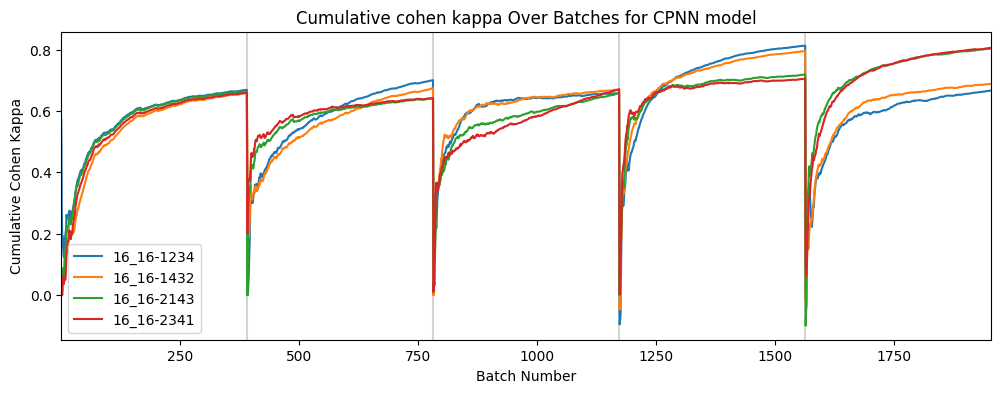

In [ ]:
df1 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-1234.csv'))
df2 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-1432.csv'))
df3 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-2143.csv'))
df4 = np.array(pd.read_csv('results/kappa-cpnn-pretrain-t4-16_16-2341.csv'))

def string_to_float(s):
    return float(s.strip('[]'))

# Apply the conversion function to each element in the array
df1 = pd.DataFrame(np.vectorize(string_to_float)(df1))
df2 = pd.DataFrame(np.vectorize(string_to_float)(df2))
df3 = pd.DataFrame(np.vectorize(string_to_float)(df3))
df4 = pd.DataFrame(np.vectorize(string_to_float)(df4))
# Create a DataFrame from the converted data
print( df1.mean(axis=1))
print( df2.mean(axis=1))
print( df3.mean(axis=1))
print( df4.mean(axis=1))

all_x=np.concatenate((df1,df2,df3,df4),axis=0)
y = np.cumsum(all_x, axis=1) / np.arange(1, all_x.shape[1] + 1)
vertical_lines_x = [all_x.shape[1], 2*all_x.shape[1], 3*all_x.shape[1],4*all_x.shape[1]]
x = list(range(1,5*all_x.shape[1] + 1))
fig, ax = plt.subplots(figsize=(12, 4))
ax.margins(x=0.0)
label_list=['16_16-1234','16_16-1432','16_16-2143','16_16-2341']

for i in vertical_lines_x:
  plt.axvline(x=i, color='#D3D3D3', linestyle='-')

for i in range(0,y.shape[0],5):
  ax.plot(x, np.concatenate((y[i],y[i+1],y[i+2],y[i+3],y[i+4]),axis=0), label= label_list[int(i/5)])
plt.xlabel('Batch Number')
plt.ylabel('Cumulative Cohen Kappa')
plt.title('Cumulative cohen kappa Over Batches for CPNN model')
plt.legend()
plt.show()

##Now we also train the pretrain model for each task of the test dataset.

list of accuracies that used for evaluating and selecting the models =  [0.64421875]
list of kappa values that used for evaluating and selecting the models =  [0.28825903]
index of selcted mask for this task 0
All batches Accuracy=  0.8734934462915601
All batches cohen kappa=  0.7451445454960246
list of accuracies that used for evaluating and selecting the models =  [0.86234375 0.918125  ]
list of kappa values that used for evaluating and selecting the models =  [0.72371563 0.83370723]
index of selcted mask for this task 1
All batches Accuracy=  0.8731577685421995
All batches cohen kappa=  0.743936093652721
list of accuracies that used for evaluating and selecting the models =  [0.65125    0.7934375  0.76328125]
list of kappa values that used for evaluating and selecting the models =  [0.30760746 0.58032262 0.51170722]
index of selcted mask for this task 1
All batches Accuracy=  0.8777253836317136
All batches cohen kappa=  0.7536554299580777
list of accuracies that used for evaluating 

All batches Accuracy=  0.8472706202046035
All batches cohen kappa=  0.694594002447908


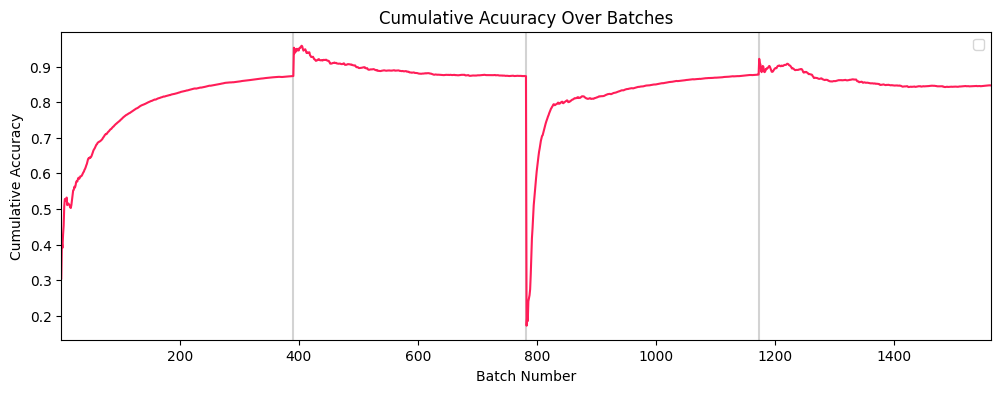

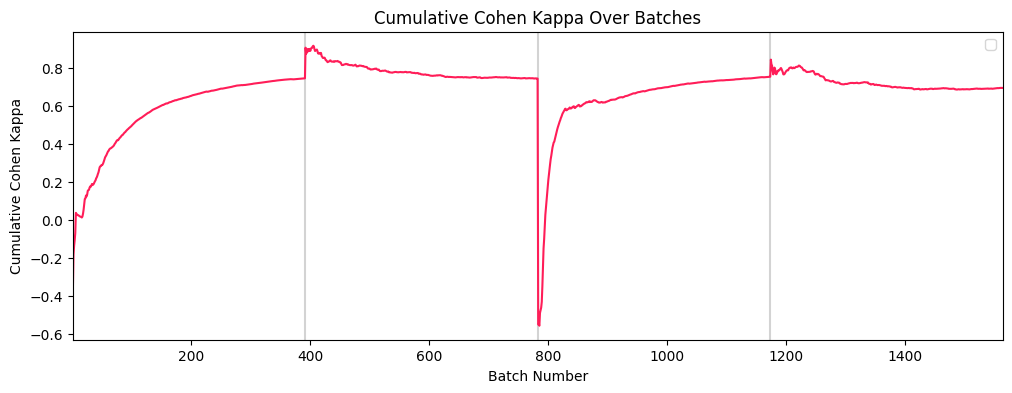

In [4]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
mask_init='uniform'
threshold_fn = 'ternarizer'
dataset = "sine_rw10_mode5_extended_6-6_1234"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_hidden50_sine_rw10_mode5_extended_6-6_1234_12.pickle'
mask_weights=[]

model=cPB(model_class=PiggyBackGRU, lr = lr,hidden_size=hidden_size,threshold_fn=threshold_fn, seq_len=seq_len, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size)
iteration=1
# first loop for the iterations, for now it is just 1 iteration.
for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column()
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


In [5]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score
import warnings

from models.cpnn_columns import cPNNColumns
from models.utils import (
    customized_loss,
    accuracy,
    cohen_kappa,
    kappa_temporal,
    get_samples_outputs,
    get_pred_from_outputs, kappa_temporal_score,
)
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
import copy
from models.PiggyBack import(
	PiggyBackGRU,
  	PiggyBackLSTM,
)

from models.network import ModifiedRNN

import matplotlib.pyplot as plt
class cPB:
    """
    Class that implements all the cPNN structure.
    """

    def __init__(
        self,
        # this parameter is useless and i should remove it
        model_class=PiggyBackGRU,
        hidden_size=50,
        device=None,
        stride: int = 1,
        lr: float = 0.01,
        seq_len: int = 5,
        base_model='gru',
        pretrain_model_addr='',
        mask_weights=[],
        mask_init='1s',
        number_of_tasks=4,
        epoch_size=5,
        **kwargs,
    ):

      self.loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
      self.stride=stride
      self.seq_len=seq_len
      self.lr=lr
      self.hidden_size = hidden_size
      self.base_model=base_model
      self.pretrain_model_addr=pretrain_model_addr
      self.mask_init=mask_init
      self.weights_list=[]
      self.selected_mask_index=[]
      self.epoch_size=epoch_size
      self.all_batch_acc=[[] for _ in range(number_of_tasks)]
      self.all_batch_kappa=[[] for _ in range(number_of_tasks)]
      self.acc_saving = [[]]
      self.cohen_kappa_saving=[[]]
      print('hidden_size',hidden_size)

      if model_class==PiggyBackGRU and pretrain_model_addr!='':
        self.model = ModifiedRNN(pretrain_model_addr=pretrain_model_addr,hidden_size=self.hidden_size,base_model=base_model,seq_len=seq_len,mask_weights=mask_weights,mask_init=mask_init)
        self.initial_weights = self.model.state_dict()

      self.final_weights=[]

    def get_seq_len(self):
        return self.seq_len

    def _cut_in_sequences(self, x, y):
        seqs_features = []
        seqs_targets = []
        for i in range(0, len(x), self.stride):
            if len(x) - i >= self.seq_len:
                seqs_features.append(x[i : i + self.seq_len, :].astype(np.float32))
                if y is not None:
                    seqs_targets.append(
                        np.asarray(y[i : i + self.seq_len], dtype=np.int_)
                    )
        return np.asarray(seqs_features), np.asarray(seqs_targets)

    def _cut_in_sequences_tensors(self, x, y):
        seqs_features = []
        seqs_targets = []
        for i in range(0, x.size()[0], self.stride):
            if x.size()[0] - i >= self.seq_len:
                seqs_features.append(
                    x[i : i + self.seq_len, :].view(1, self.seq_len, x.size()[1])
                )
                seqs_targets.append(y[i : i + self.seq_len].view(1, self.seq_len))
        seq_features = torch.cat(seqs_features, dim=0)
        seqs_targets = torch.cat(seqs_targets, dim=0)
        return seq_features, seqs_targets

    def _convert_to_tensor_dataset(self, x, y=None):

        x, y = self._cut_in_sequences(x, y)
        x = torch.tensor(x)
        if len(y) > 0:
            y = torch.tensor(y).type(torch.LongTensor)
            return data_utils.TensorDataset(x, y)
        return x

    def _load_batch(self, x: np.array, y: np.array = None):

        batch = self._convert_to_tensor_dataset(x, y)
        batch_loader = DataLoader(
            batch, batch_size=batch.tensors[0].size()[0], drop_last=False
        )
        y_seq = None
        for x, y_seq in batch_loader:  # only to take x and y from loader
            break
        y = torch.tensor(y)
        return x, y, y_seq


    def learn_many(self,x,y,task_number):

      self.model=self.rebuild_model(task_number)

      x = np.array(x)
      y = list(y)

      optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
      x, y, _ = self._load_batch(x, y)
      #print('inside the train and fit', x.shape)
      for i in range(0,self.epoch_size):
        y_pred = self.model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)
        loss = self.loss_fn(y_pred, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # update weights
        optimizer.step()
      self.update_weights(task_number)

    def mask_return(self):
      return self.model.state_dict()
    def update_weights(self,task_number):
      self.weights_list[task_number]=copy.deepcopy(self.model.state_dict())

    def rebuild_model(self,task_number):
      param_list=[]
      for params in self.weights_list[task_number]:
        param_list.append(params)

      mask_weights=[]
      mask_weights.append(self.weights_list[task_number][param_list[-5]])
      mask_weights.append(self.weights_list[task_number][param_list[-4]])
      mask_weights.append(self.weights_list[task_number][param_list[-3]])
      mask_weights.append(self.weights_list[task_number][param_list[-2]])
      mask_weights.append(self.weights_list[task_number][param_list[-1]])
      self.model=ModifiedRNN(pretrain_model_addr=self.pretrain_model_addr, hidden_size= self.hidden_size,
                             base_model=self.base_model,seq_len=self.seq_len,mask_weights=mask_weights,
                             mask_init=self.mask_init)
      return self.model

    def final_weights_saving(self):
      self.final_weights.append(copy.deepcopy(self.model.state_dict()))

    def predict_many(self,x,y,task_number):
      x = np.array(x)
      y = list(y)
      x, y, _ = self._load_batch(x, y)
      #print('input shape', x.shape)
      y_pred = self.model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      kappa=cohen_kappa(y,pred).item()
      acc=accuracy_score(np.array(y),np.array(pred))
      self.acc_saving[task_number].append(acc)
      self.cohen_kappa_saving[task_number].append(kappa)
      #return acc, kappa

    def initial_weights_returning(self):
      return self.initial_weights

    def weights_copy(self, task_number):
      weights_list=[]
      for i in range(0,task_number-1):
        self.weights_list.append(copy.deepcopy(self.final_weights[i]))
      self.weights_list.append(copy.deepcopy(self.initial_weights))

    def add_new_column(self):
      avg_acc= np.mean(self.acc_saving, axis=1)
      avg_cohen_kappa = np.mean(self.cohen_kappa_saving, axis=1)
      index_of_best_acc = np.argmax(avg_acc)
      self.selected_mask_index.append(index_of_best_acc)
      print('list of accuracies that used for evaluating and selecting the models = ',avg_acc)
      print('list of kappa values that used for evaluating and selecting the models = ',avg_cohen_kappa)
      print('index of selcted mask for this task',index_of_best_acc)
      return index_of_best_acc
    def save_final_metrics(self,task,best_mask_index):
      self.all_batch_acc[task-1]=copy.deepcopy(self.acc_saving[best_mask_index])
      self.all_batch_kappa[task-1]=copy.deepcopy(self.cohen_kappa_saving[best_mask_index])
      print('All batches Accuracy= ', np.mean(self.all_batch_acc[task-1]))
      print('All batches cohen kappa= ', np.mean(self.all_batch_kappa[task-1]))
      self.acc_saving = [[] for _ in range(task+1)]
      self.cohen_kappa_saving=[[] for _ in range(task+1)]

    def plotting(self):

      x0=np.cumsum(self.all_batch_acc[0]) / np.arange(1, len(self.all_batch_acc[0]) + 1)
      x1=np.cumsum(self.all_batch_acc[1]) / np.arange(1, len(self.all_batch_acc[1]) + 1)
      x2=np.cumsum(self.all_batch_acc[2]) / np.arange(1, len(self.all_batch_acc[2]) + 1)
      x3=np.cumsum(self.all_batch_acc[3]) / np.arange(1, len(self.all_batch_acc[3]) + 1)
      all_x=np.concatenate((x0,x1,x2,x3),axis=0)
      vertical_lines_x = [len(x0), len(x0)+len(x1), len(x0)+len(x1)+len(x2)]
      y = all_x
      x = list(range(1,len(all_x) + 1))
      fig, ax = plt.subplots(figsize=(12, 4))
      ax.margins(x=0.0)
      for i in vertical_lines_x:
          plt.axvline(x=i, color='#D3D3D3', linestyle='-')
      ax.plot(x, y, color='#ff1d58')
      plt.xlabel('Batch Number')
      plt.ylabel('Cumulative Accuracy')
      plt.title('Cumulative Acuuracy Over Batches')
      plt.legend()
      plt.show()

      x0=np.cumsum(self.all_batch_kappa[0]) / np.arange(1, len(self.all_batch_kappa[0]) + 1)
      x1=np.cumsum(self.all_batch_kappa[1]) / np.arange(1, len(self.all_batch_kappa[1]) + 1)
      x2=np.cumsum(self.all_batch_kappa[2]) / np.arange(1, len(self.all_batch_kappa[2]) + 1)
      x3=np.cumsum(self.all_batch_kappa[3]) / np.arange(1, len(self.all_batch_kappa[3]) + 1)
      all_x=np.concatenate((x0,x1,x2,x3),axis=0)
      y = all_x
      fig, ax = plt.subplots(figsize=(12, 4))
      ax.margins(x=0.0)
      for i in vertical_lines_x:
          plt.axvline(x=i, color='#D3D3D3', linestyle='-')
      ax.plot(x, y, color='#ff1d58')
      plt.xlabel('Batch Number')
      plt.ylabel('Cumulative Cohen Kappa')
      plt.title('Cumulative Cohen Kappa Over Batches')
      plt.legend()
      plt.show()

In [ ]:
pd.DataFrame(model.all_batch_acc).to_csv('results/acc-CPB-16_16-1432-t1.csv', index=False)
pd.DataFrame(model.all_batch_kappa).to_csv('results/kappa-CPB-16_16-1432-t1.csv', index=False)

In [ ]:
df1 = np.array(pd.read_csv('results/kappa-16_16-1234-4.csv'))
df2 = np.array(pd.read_csv('results/kappa-16_16-1432-4.csv'))
df3 = np.array(pd.read_csv('results/kappa-16_16-2143-4.csv'))
df4 = np.array(pd.read_csv('results/kappa-16_16-2341-4.csv'))
all_x=np.concatenate((df1,df2,df3,df4),axis=0)
y = np.cumsum(all_x, axis=1) / np.arange(1, all_x.shape[1] + 1)
vertical_lines_x = [all_x.shape[1], 2*all_x.shape[1], 3*all_x.shape[1]]
x = list(range(1,4*all_x.shape[1] + 1))
fig, ax = plt.subplots(figsize=(12, 4))
ax.margins(x=0.0)
label_list=['16_16-1234','16_16-1432','16_16-2143','16_16-2341']

for i in vertical_lines_x:
  plt.axvline(x=i, color='#D3D3D3', linestyle='-')

for i in range(0,y.shape[0],4):
  ax.plot(x, np.concatenate((y[i],y[i+1],y[i+2],y[i+3]),axis=0), label= label_list[int(i/4)])
plt.xlabel('Batch Number')
plt.ylabel('Cumulative Cohen Kappa')
plt.title('Cumulative Cohen Kappa Over Batches')
plt.legend()
plt.show()